# Constructing the Model

Here we will build the underlying model behind our Fruit Ninja Bot. I will walk through the steps that I took to build this model so that you can recreate it. Ensure that you have all the dependencies installed from `requirements.txt` prior to starting this notebook. Then verify that you have a complete dataset in `dataset/yolo`:

In [1]:
from pathlib import Path

project_root = Path.cwd().parent
dataset_root = project_root / "dataset" / "yolo"
data_yaml = dataset_root / "data.yaml"

print("Project root:", project_root)
print("Dataset root:", dataset_root)
print("Found data.yaml:", data_yaml.exists())

print(data_yaml.read_text())

Project root: C:\Users\azure\Documents\Fruit Ninja Bot
Dataset root: C:\Users\azure\Documents\Fruit Ninja Bot\dataset\yolo
Found data.yaml: True
# YOLO dataset config for Fruit Ninja
# Paths are relative to this data.yaml file

train: images/train
val: images/val

nc: 2
names: ['bomb', 'fruit']



I will be training a YOLO model from ultralytics to both speed up the training time and to have an efficient, lightweight model since I want to prioritize speed over accuracy. As such, I will use a pre-trained YOLOv11 small model to prioritize the speed at which it can process images.

In [2]:
from ultralytics import YOLO

models_dir = project_root / "models"
model = YOLO("yolo11s.pt")

name="fruitninja_yolo_s_640" # edit to match your chosen model
run_dir = models_dir / "fruitninja_yolo_s_640"

if run_dir.exists():
        best_weights = run_dir / "weights" / "best.pt"
        model = YOLO(str(best_weights))
else :
    results = model.train(
        data=str(data_yaml),
        epochs=120,
        imgsz=640,
        batch=-1,
        name=name,
        patience=50,
        project=str(models_dir),
    )

New https://pypi.org/project/ultralytics/8.3.238 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.237  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\azure\Documents\Fruit Ninja Bot\dataset\yolo\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=

### Analyzing the model

Let's see how our model performs.

In [5]:
run_dir = models_dir / "fruitninja_yolo_s_640"
best_weights = run_dir / "weights" / "best.pt"

model = YOLO(str(best_weights))
eval_name = "fruitninja_eval_s_640"

metrics = model.val(
    data=str(data_yaml),
    imgsz=640,
    batch=1,
    project=str(models_dir),
    name=eval_name,
)

Ultralytics 8.3.237  Python-3.13.9 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1518.4624.0 MB/s, size: 162.4 KB)
val: Scanning C:\Users\azure\Documents\Fruit Ninja Bot\dataset\yolo\labels\val.cache... 182 images, 31 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 182/182 449.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 182/182 86.5it/s 2.1s0.0s
                   all        182        322      0.962      0.967      0.973      0.912
                  bomb         68         96      0.984      0.969      0.976        0.9
                 fruit        124        226      0.939      0.965      0.969      0.923
Speed: 0.6ms preprocess, 7.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to C:\Users\azure\Documents\Fruit Ninja Bot\models\fruitninja_eval_s_640

In [6]:
print("Detection Metrics")
print(f"mAP50-95 (overall): {metrics.box.map:.3f}")
print(f"mAP50     (overall): {metrics.box.map50:.3f}")

class_names = ["bomb", "fruit"]
print("\nPer-class AP50-95:")
for name, ap in zip(class_names, metrics.box.maps):
    print(f"  {name:5s}: {ap:.3f}")

Detection Metrics
mAP50-95 (overall): 0.912
mAP50     (overall): 0.973

Per-class AP50-95:
  bomb : 0.900
  fruit: 0.923


Here we have two YOLO metrics commonly used, mAP50 and mAP50-95 (mean Average Precision @ IoU 0.5 and mean Average Precision averaged over IoU 0.5 to 0.95). IoU means Intersection over Union, and essentially means the percent of the total area covered by the predicted bounding box and the ground truth. mAP50 tells us how well a prediction is made if the model predicts a bounding box that overlaps the ground truth box by at least 50%. mAP50-95 is the same metric, but overlaps from 0.5 to 0.95 are used and averaged, and is much harder to score well in. The fact that our model is scoring 0.9 and above for both of these metrics indicates that our model is doing superb.

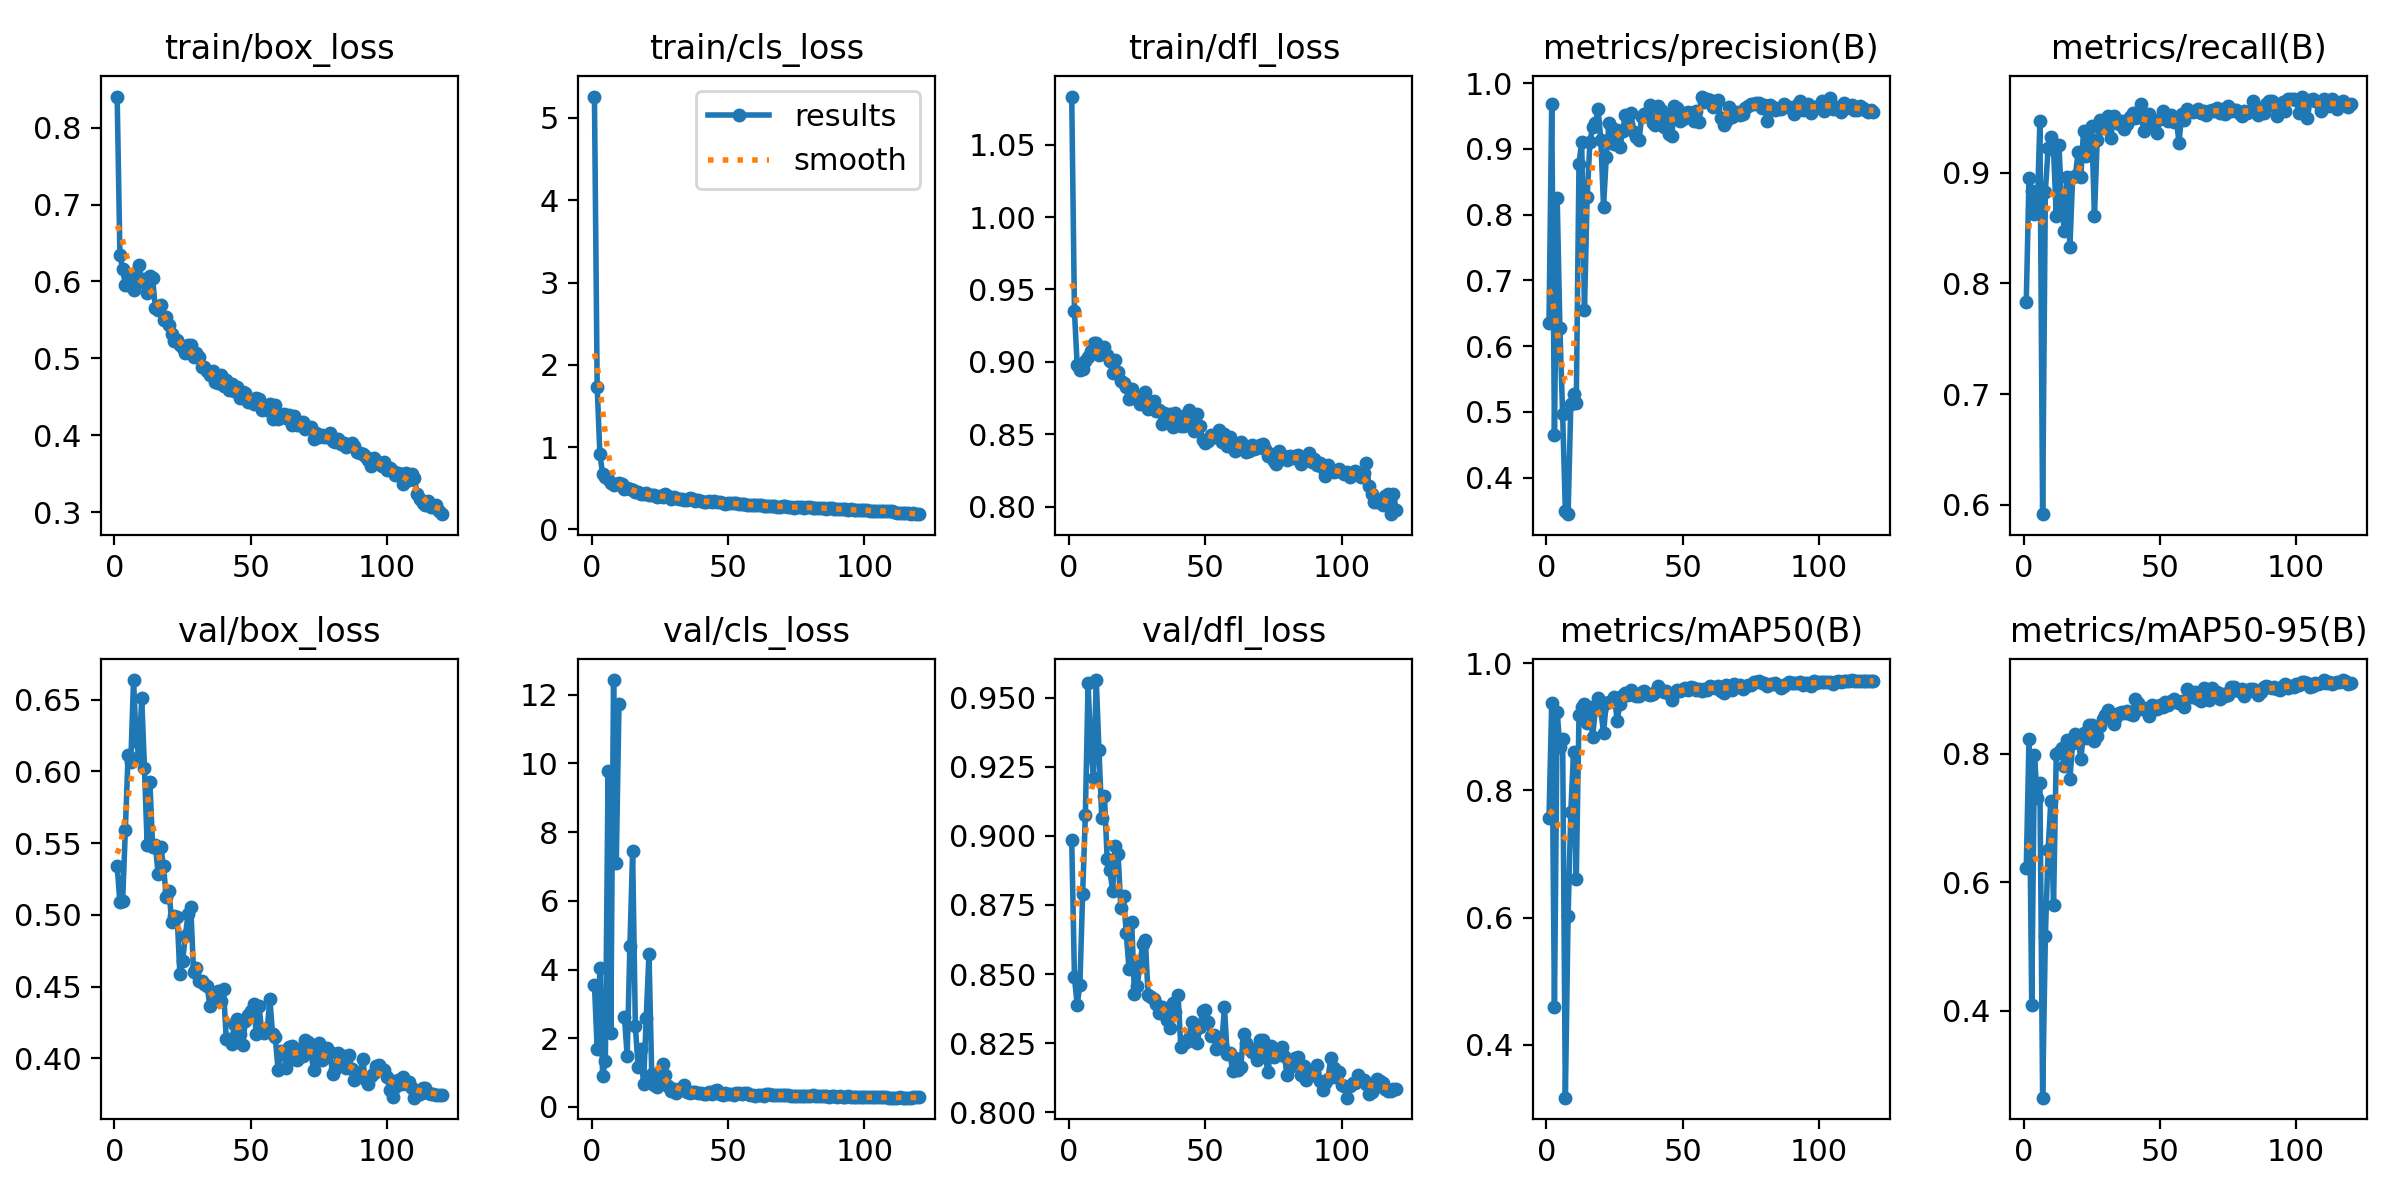

In [7]:
from IPython.display import Image, display

run_name = "fruitninja_yolo_s_640"
run_dir = models_dir / run_name

training_results = run_dir / "results.png"
display(Image(filename=str(training_results)))

Here we can see the different kinds of losses that YOLO tracks. Box loss is how well the predicted bounding boxes match the ground truth/real boxes. CLS loss, or class loss, describes how well the model assigns the correct classes. Finally, DFL loss or Distribution Focal Loss is where the model is required to learn a probability distribution of how likely a bounding box is to be. Since our model is plateauing at low loss values, the model is doing well. Perhaps, juding by box_loss and dfl loss, the model could run for more epochs, but it isn't strictly required.

confusion_matrix.png


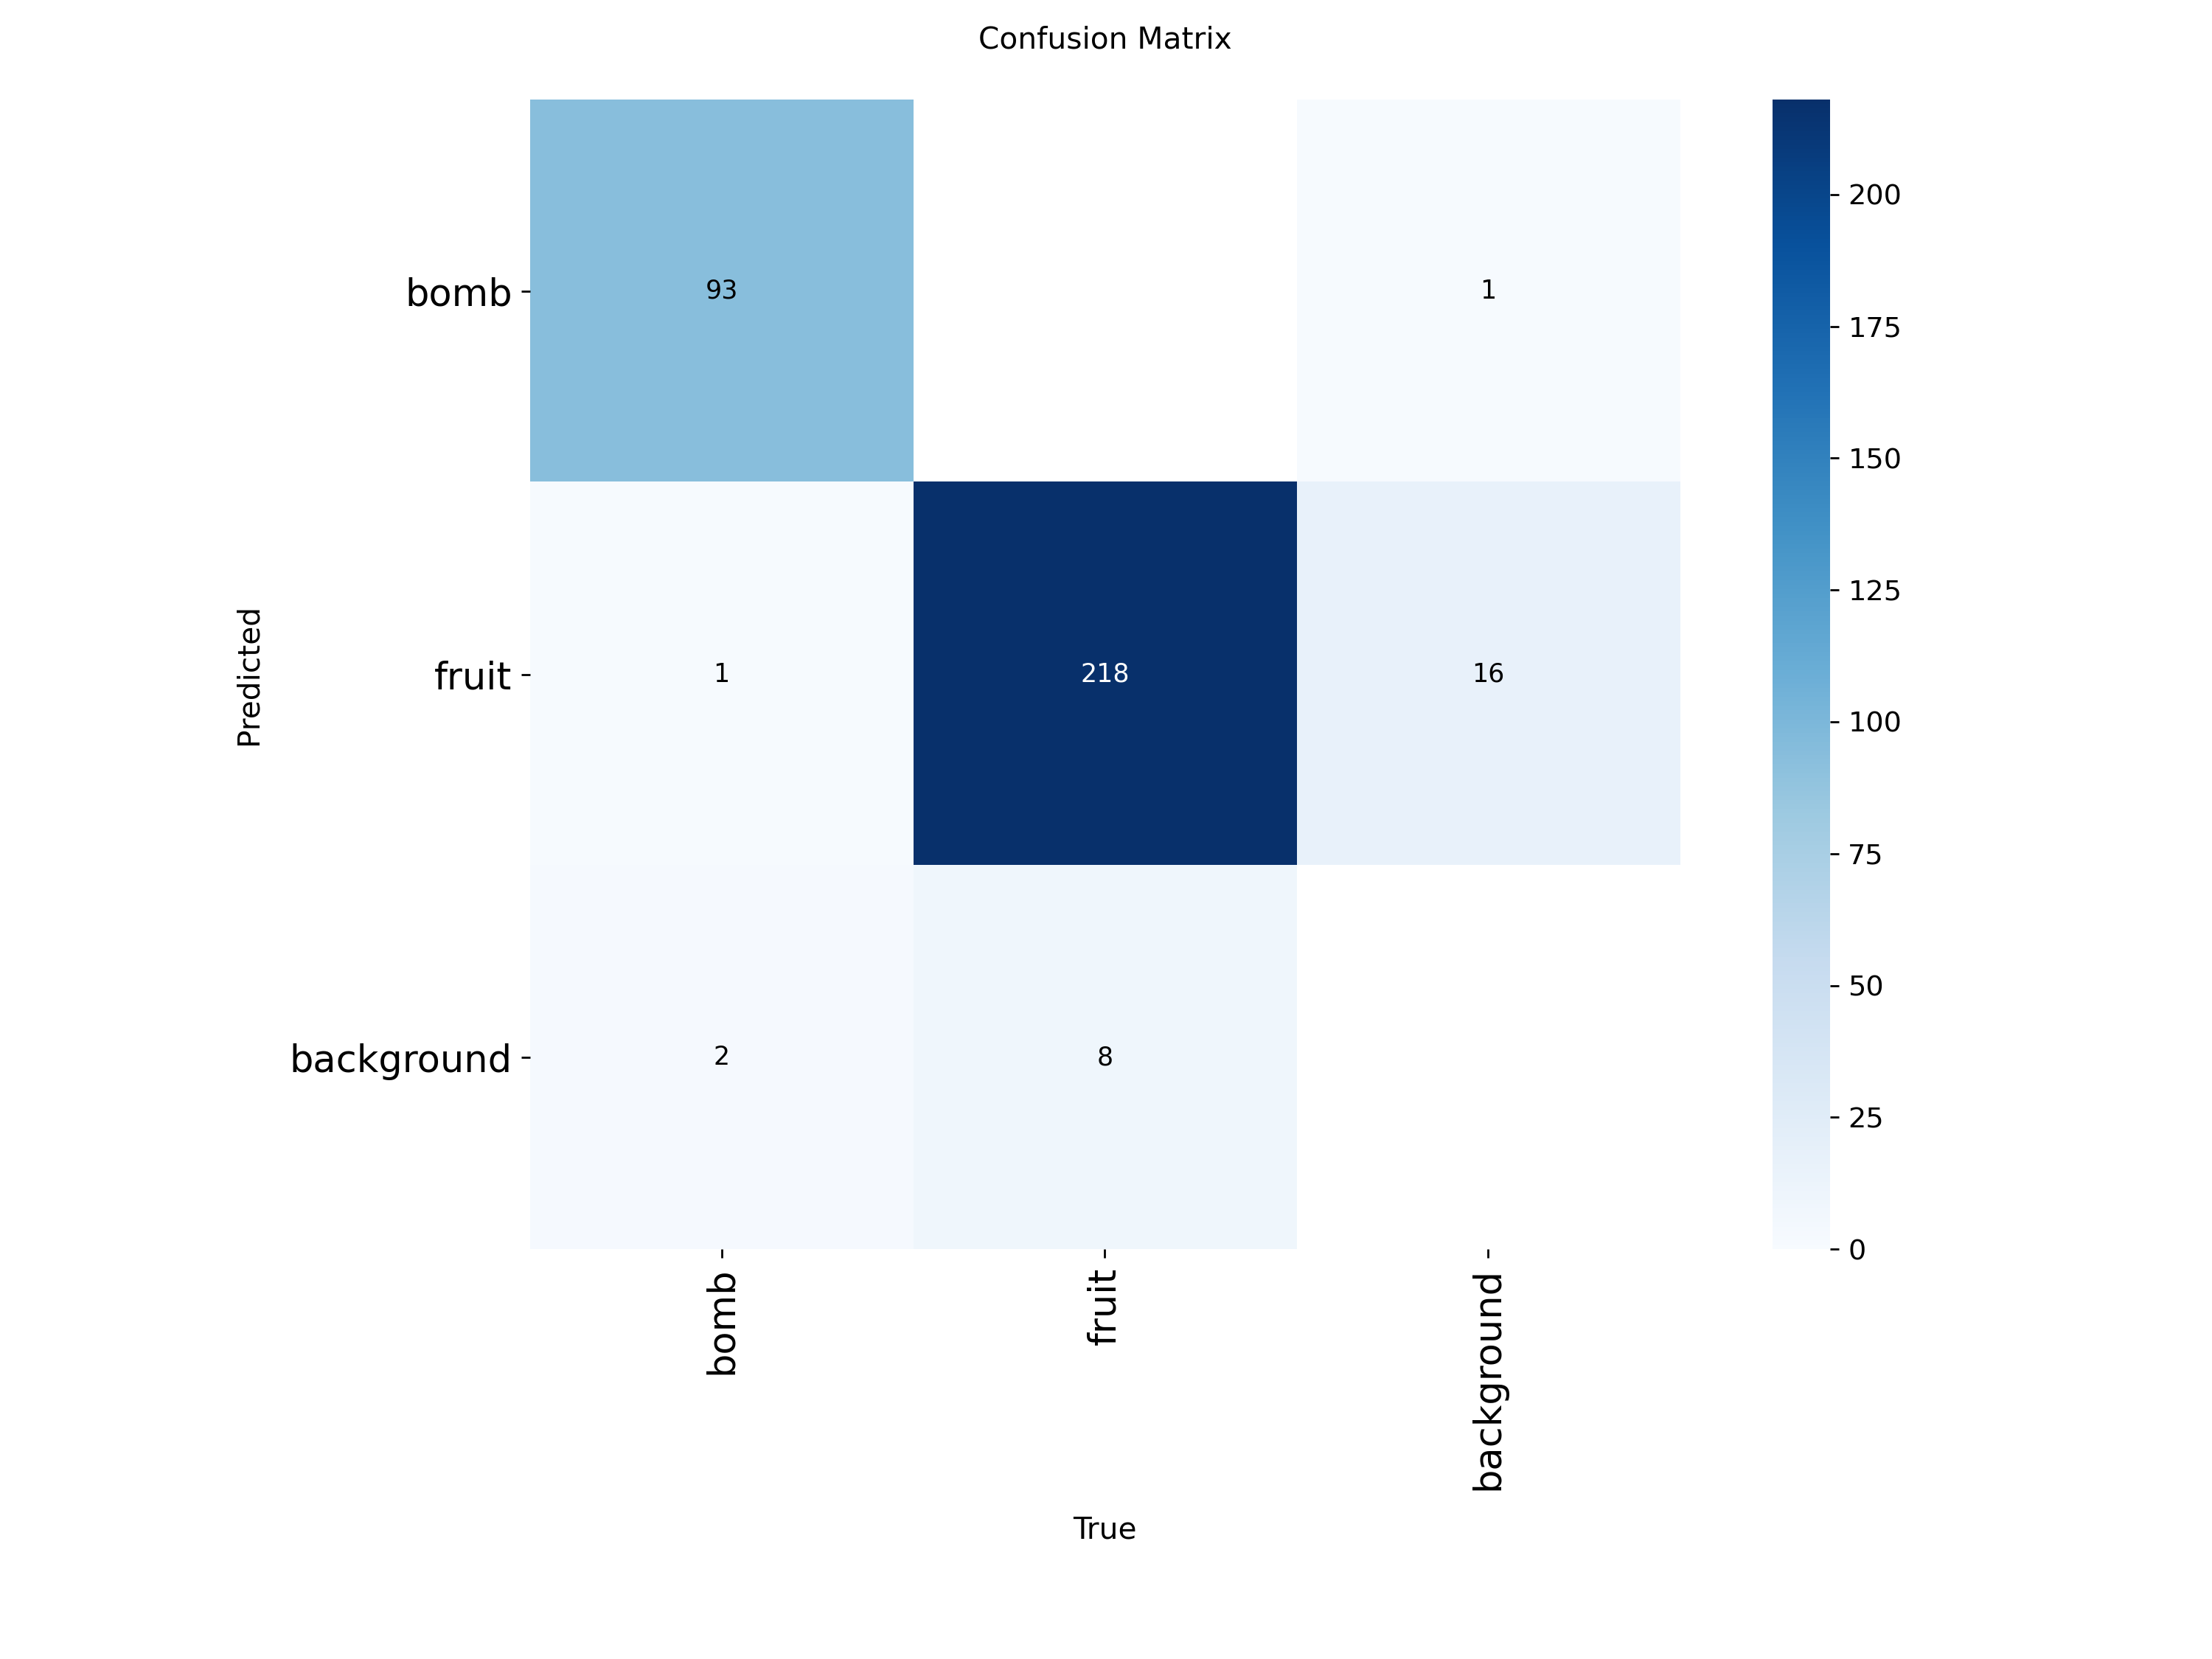

confusion_matrix_normalized.png


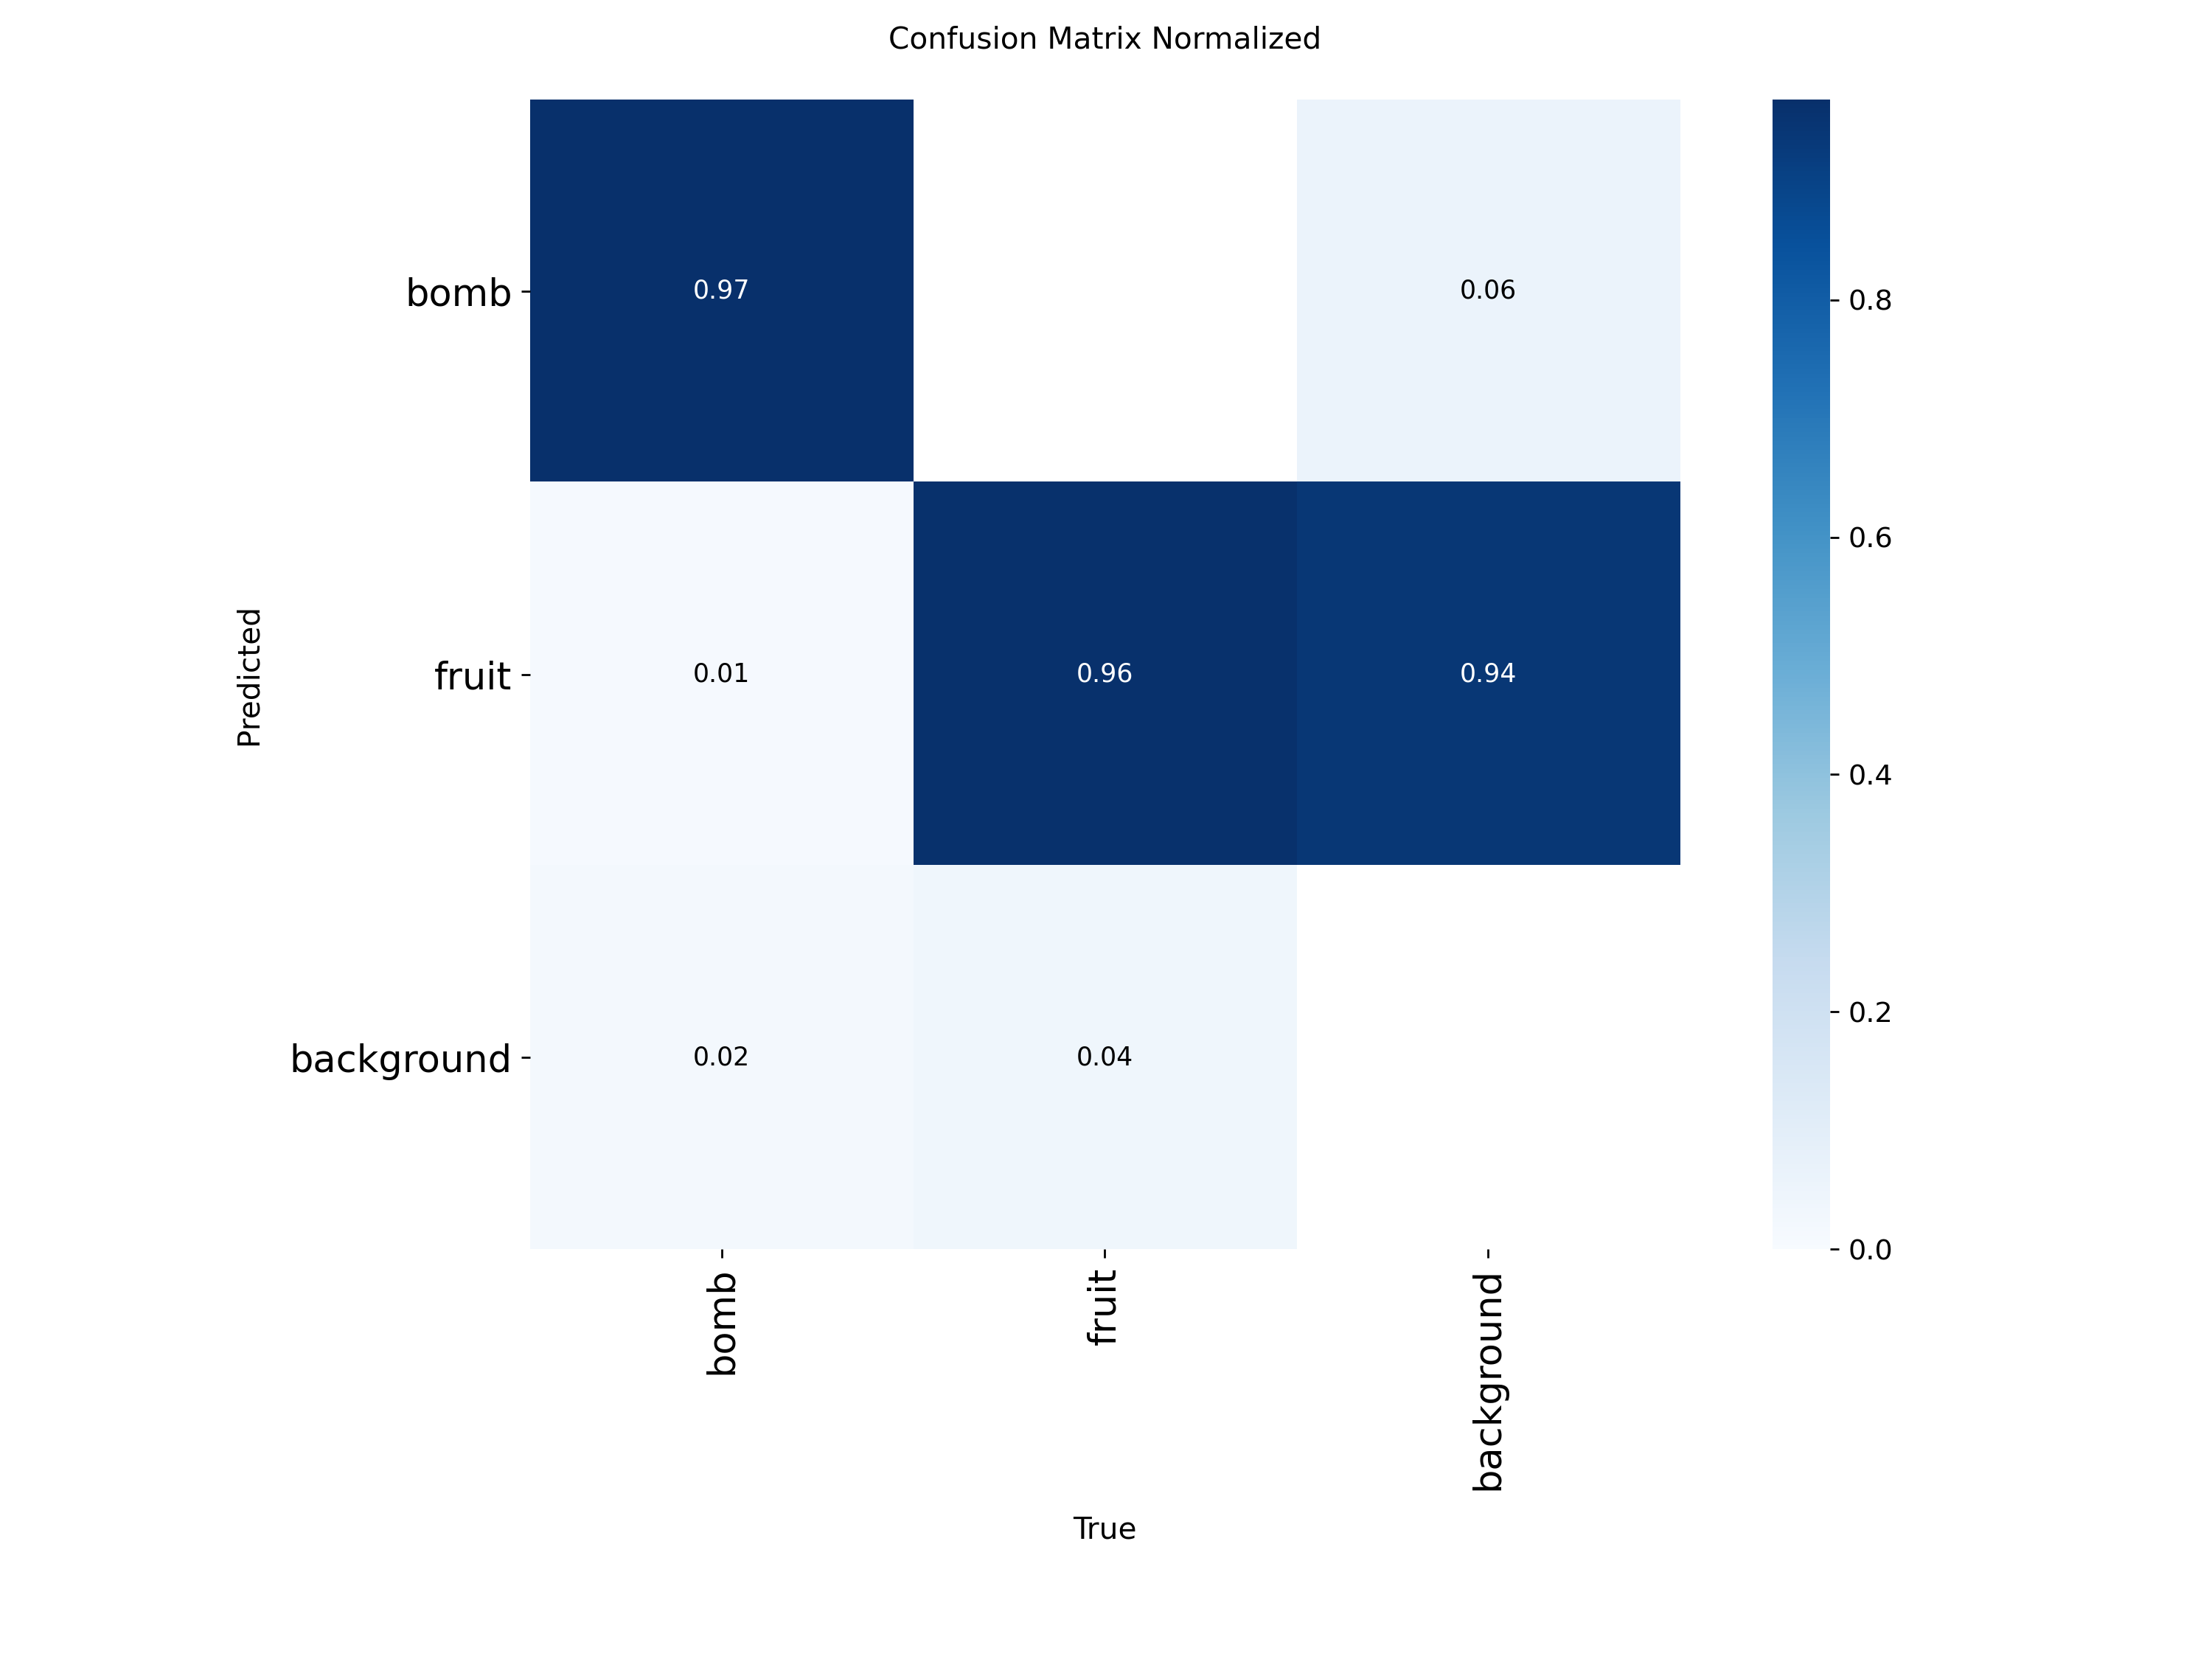

BoxPR_curve.png


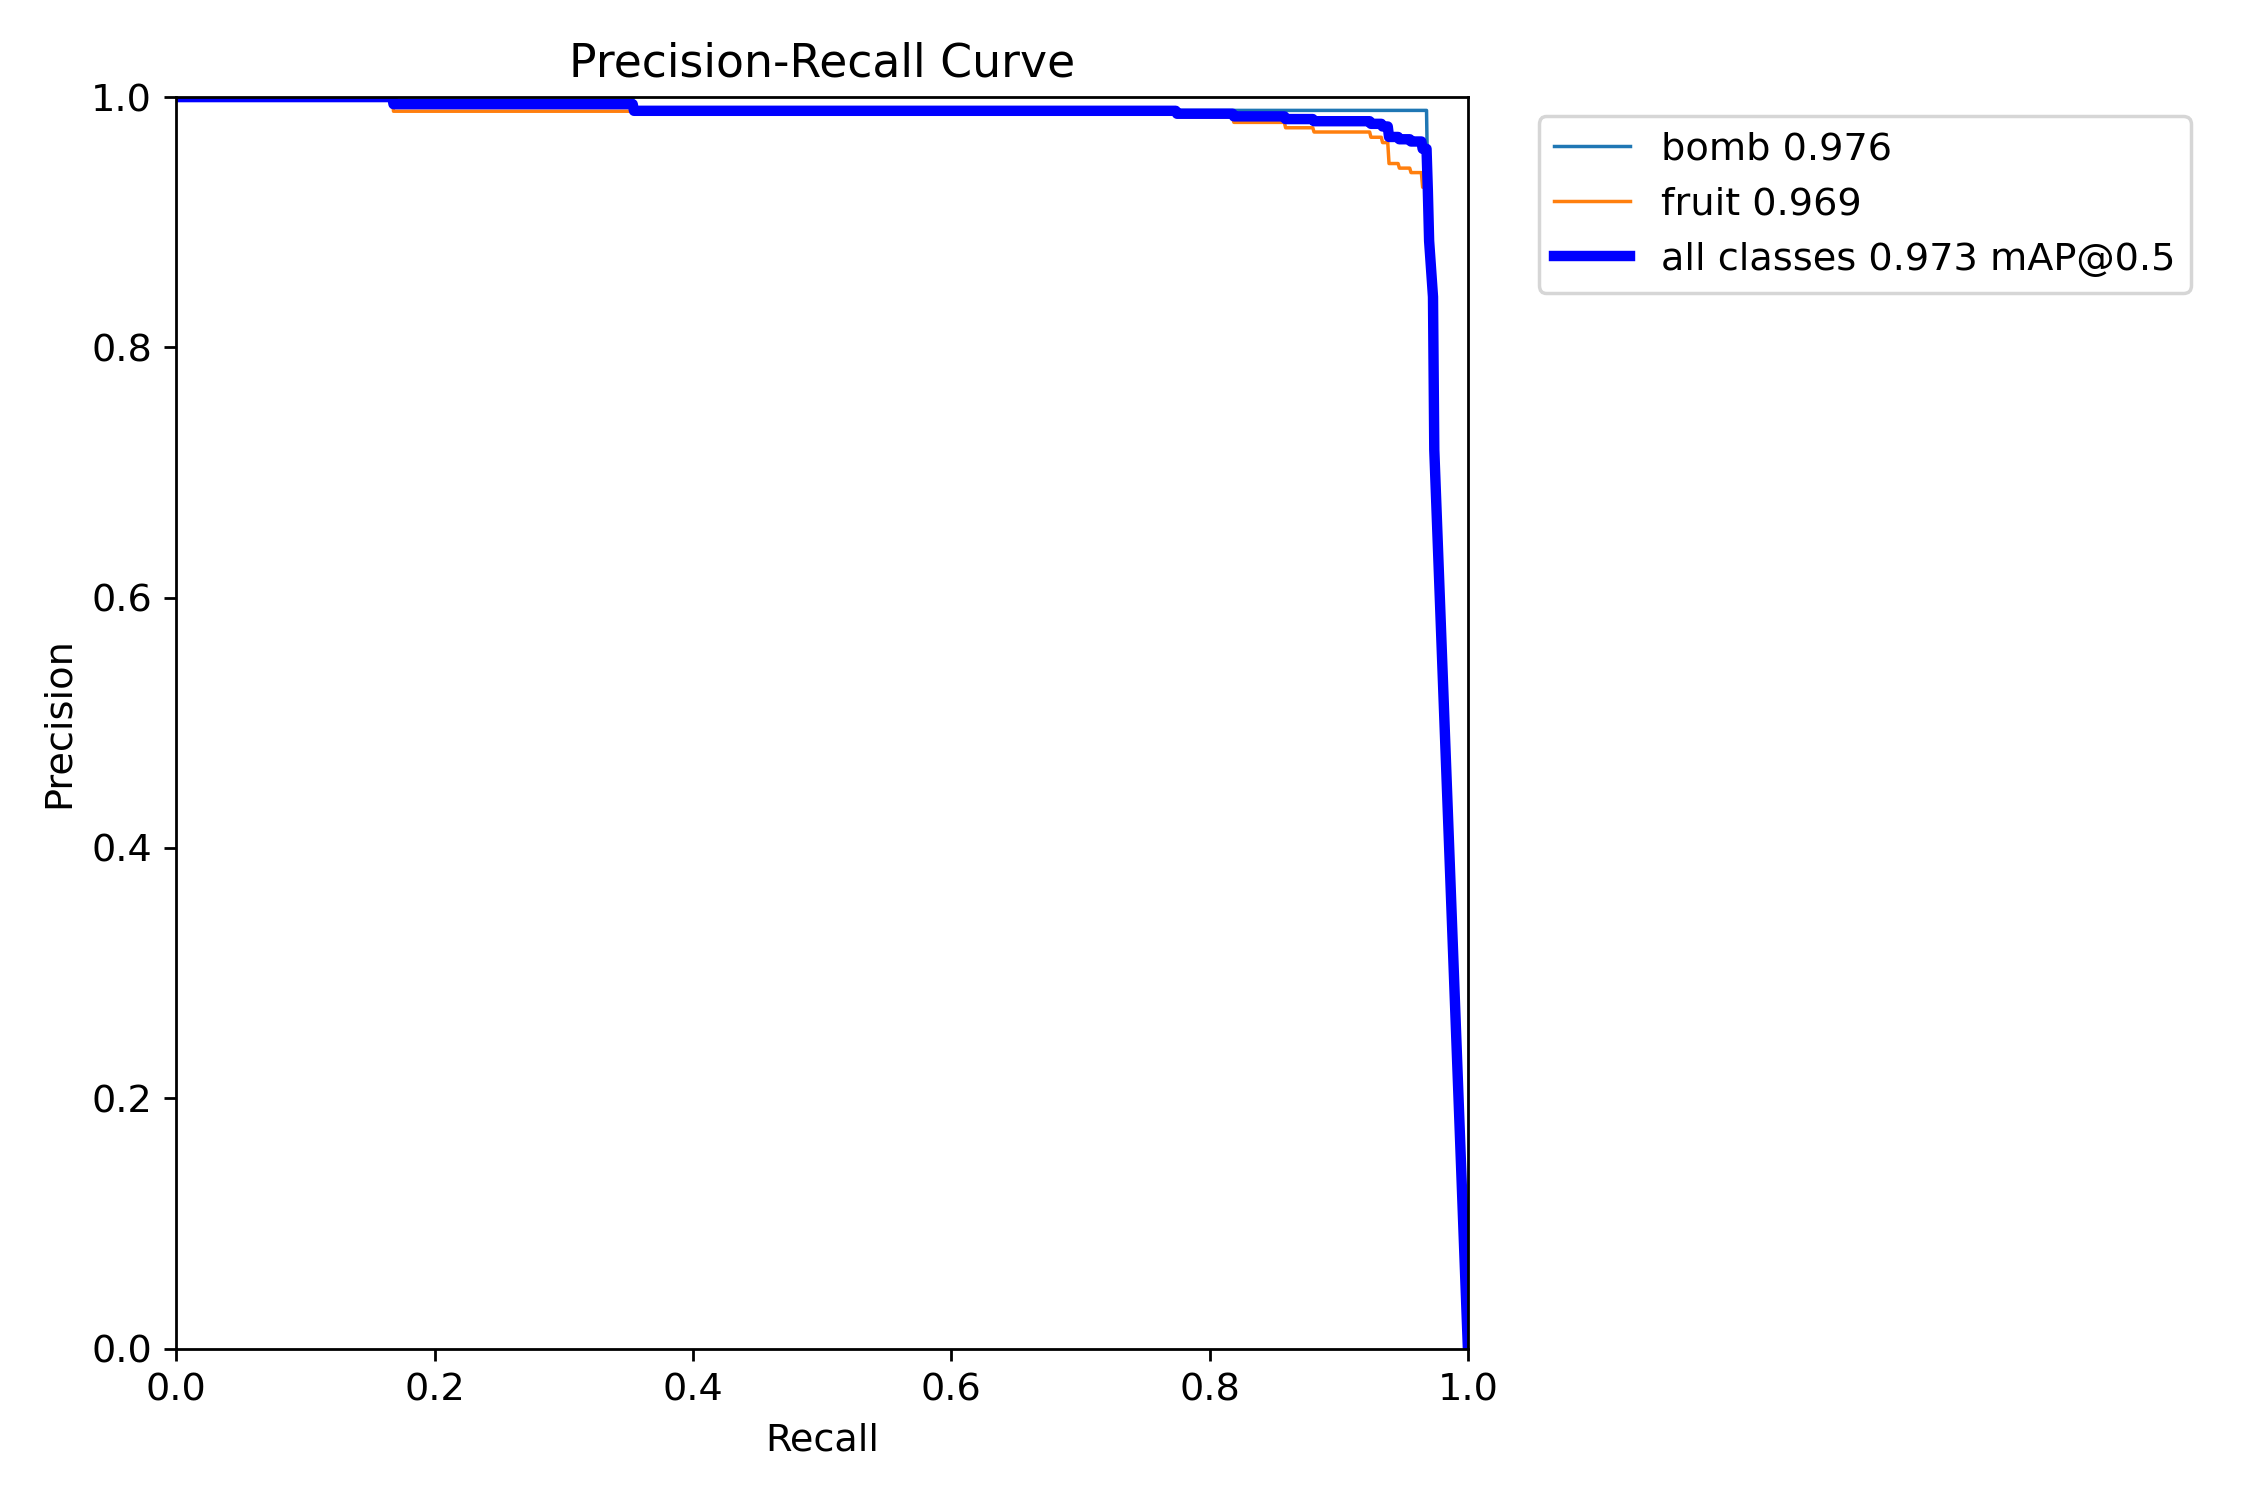

BoxF1_curve.png


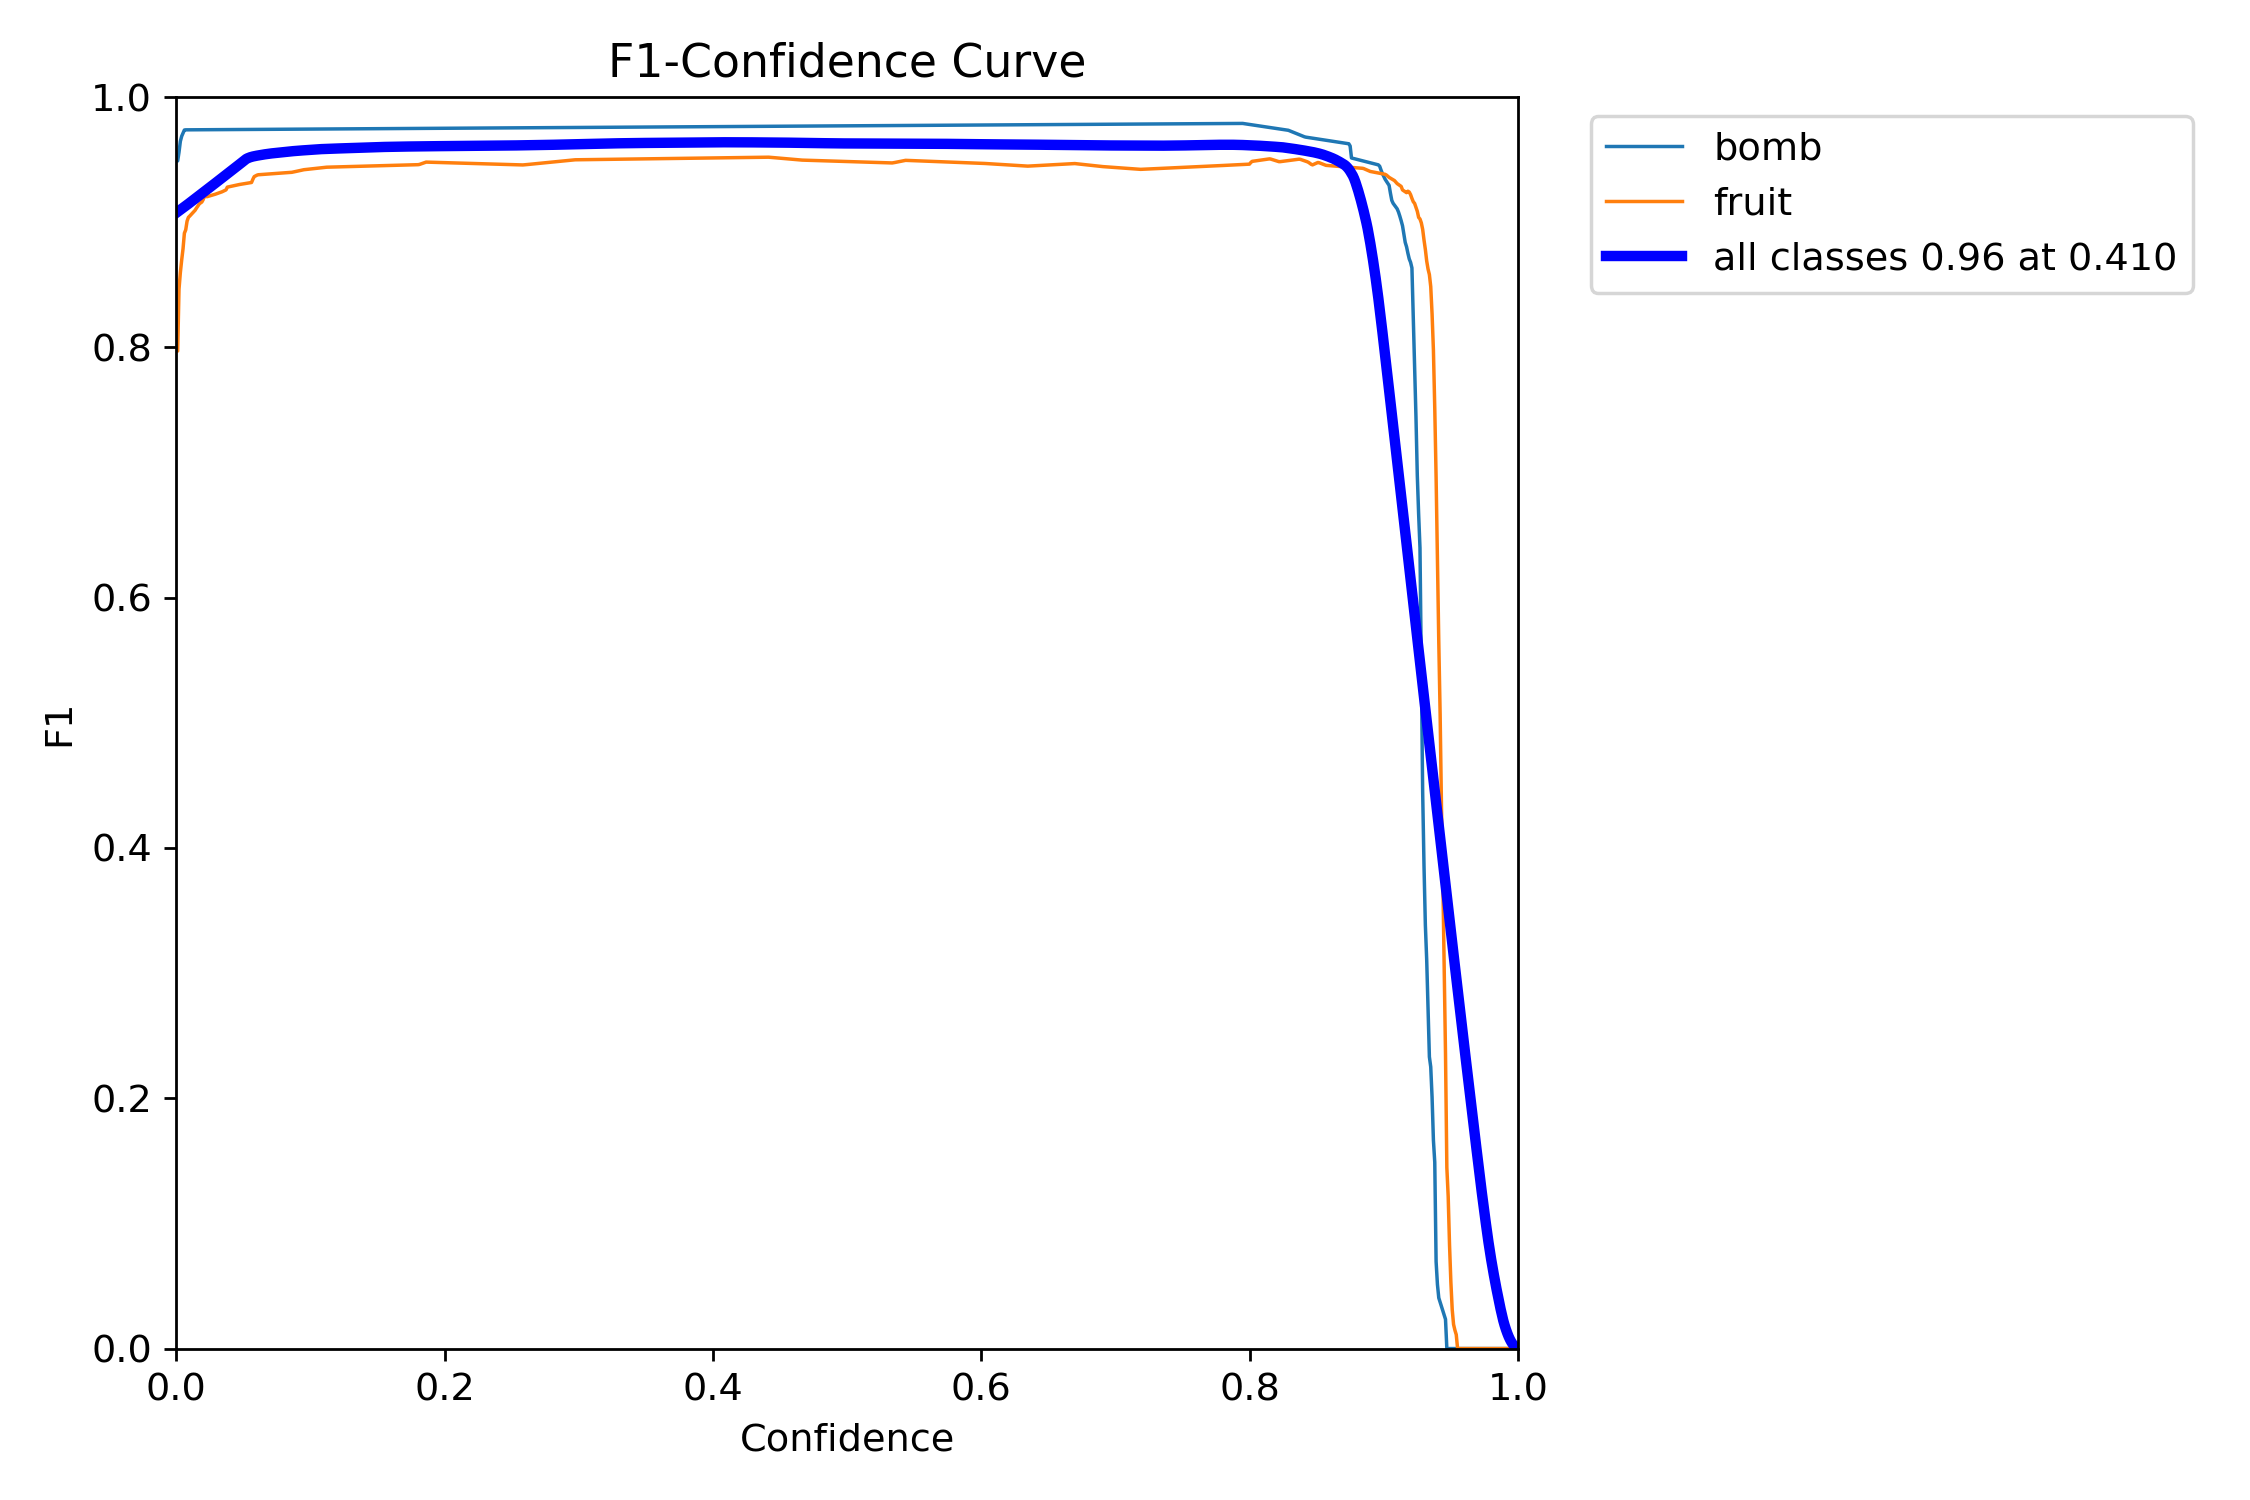

BoxP_curve.png


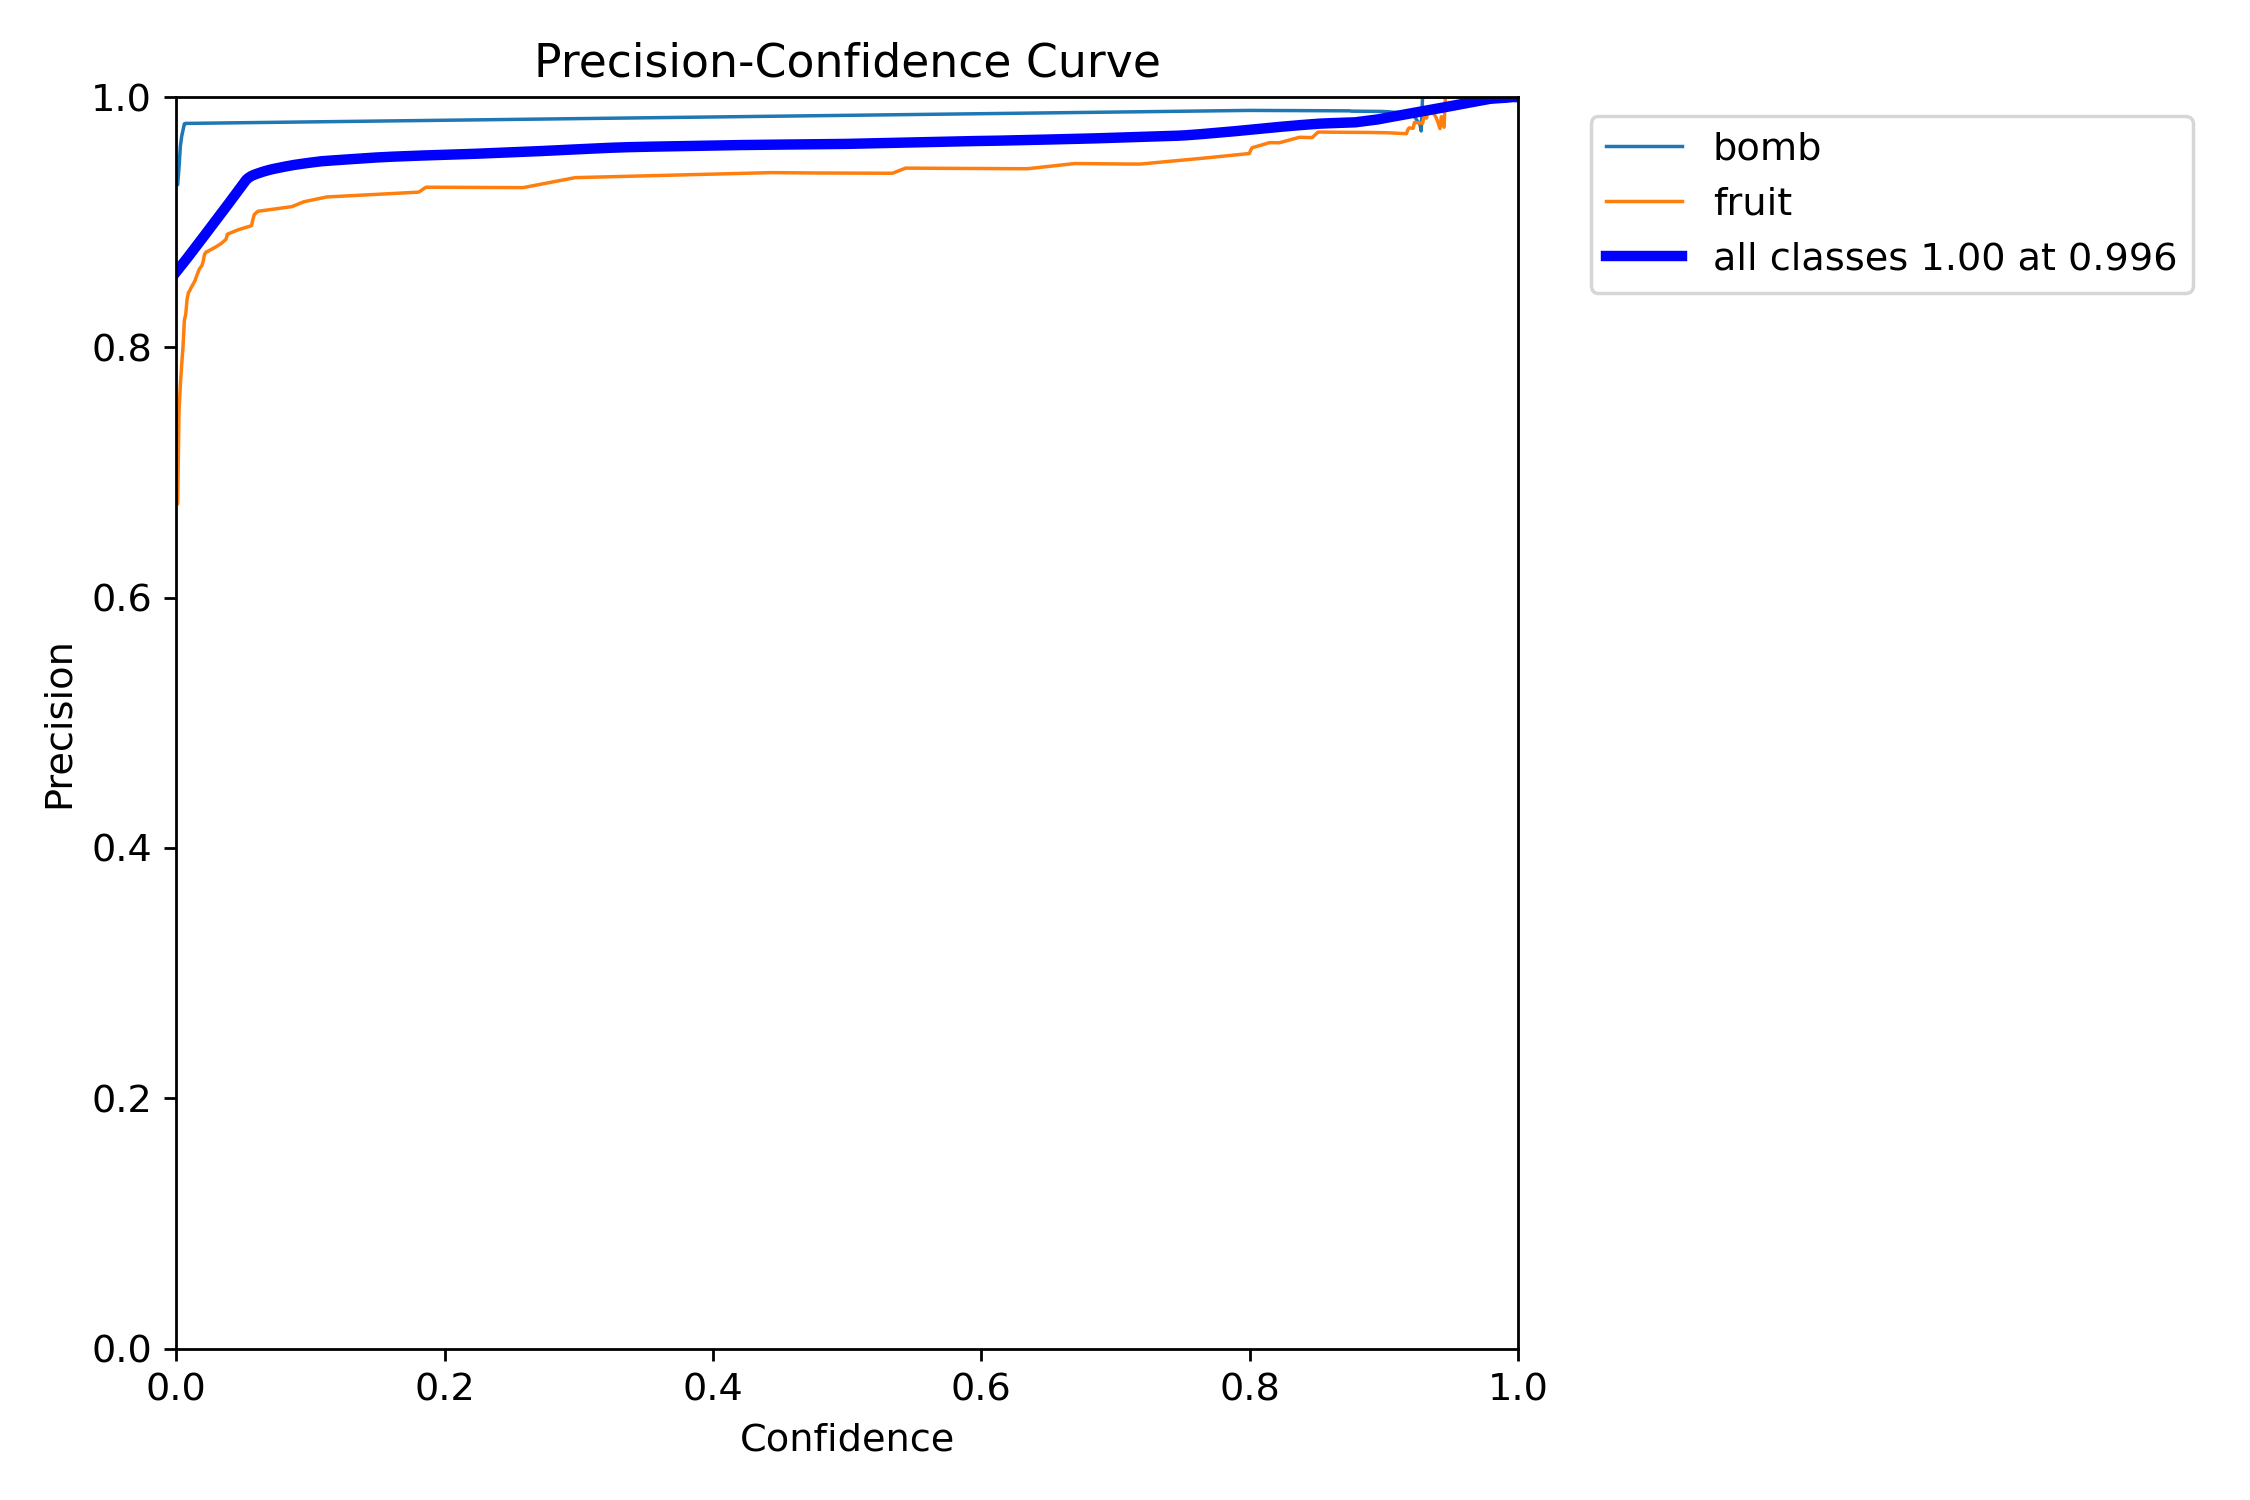

BoxR_curve.png


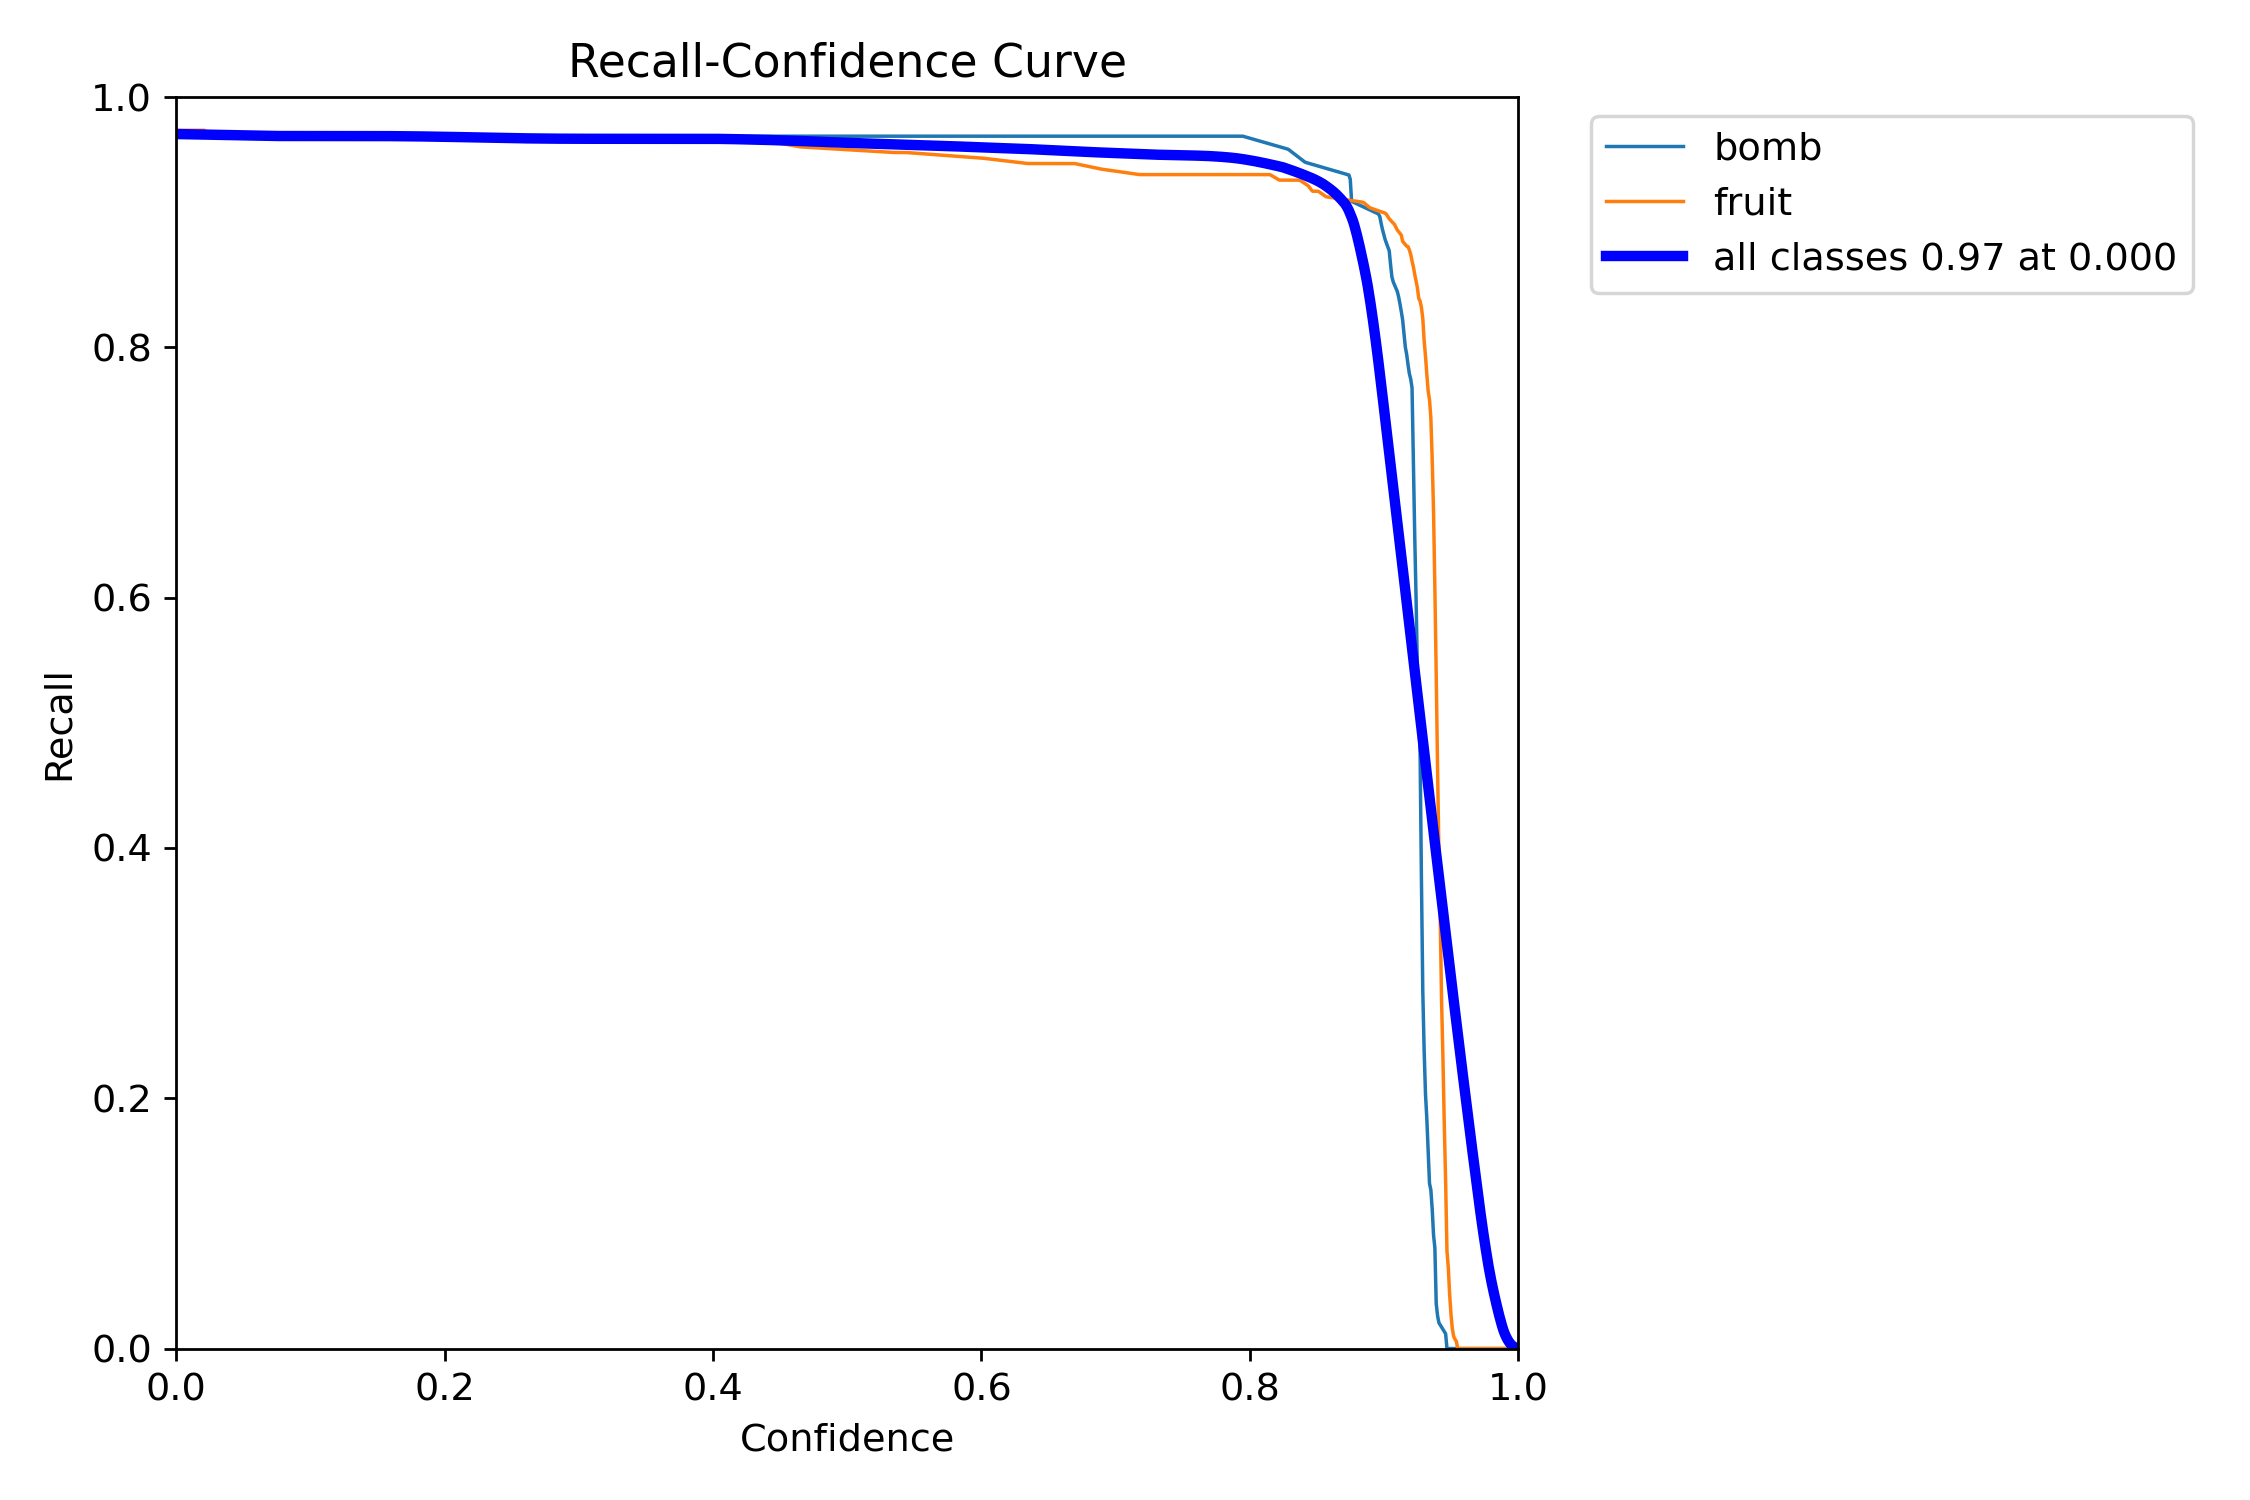

In [9]:
eval_dir = models_dir / eval_name

for fname in ["confusion_matrix.png",
              "confusion_matrix_normalized.png",
              "BoxPR_curve.png",
              "BoxF1_curve.png",
              "BoxP_curve.png",
              "BoxR_curve.png"]:
    f = eval_dir / fname
    if f.exists():
        print(fname)
        display(Image(filename=str(f)))
    else:
        print("Missing:", f.relative_to(project_root))

Above are several important metrics for determining the effectiveness of our model.

Precision recall tells us the model's performance at different confidence thresholds. With a steep and high curve, the model does better as the area underneath corresponds to AP.
The F1 curve tells us at which confidence threshold is the best for balancing precision and recall.

Finally, the confusion matrix shows us the model's overall performance, with a strong diagonal being indicative of high performance.

Below are some sample visualizations of the model.

Found 1716 images.

0: 384x640 2 bombs, 2 fruits, 4.7ms
1: 384x640 4 fruits, 4.7ms
2: 384x640 (no detections), 4.7ms
3: 384x640 1 bomb, 4.7ms
4: 384x640 2 bombs, 1 fruit, 4.7ms
5: 384x640 (no detections), 4.7ms
6: 384x640 2 bombs, 1 fruit, 4.7ms
7: 384x640 2 bombs, 4.7ms
8: 384x640 (no detections), 4.7ms
9: 384x640 1 fruit, 4.7ms
10: 384x640 (no detections), 4.7ms
11: 384x640 1 bomb, 4.7ms
Speed: 0.8ms preprocess, 4.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\azure\Documents\Fruit Ninja Bot\models\fruitninja_sample_preds
Saved annotated images under: models\fruitninja_sample_preds
fruitninja1_000127.jpg


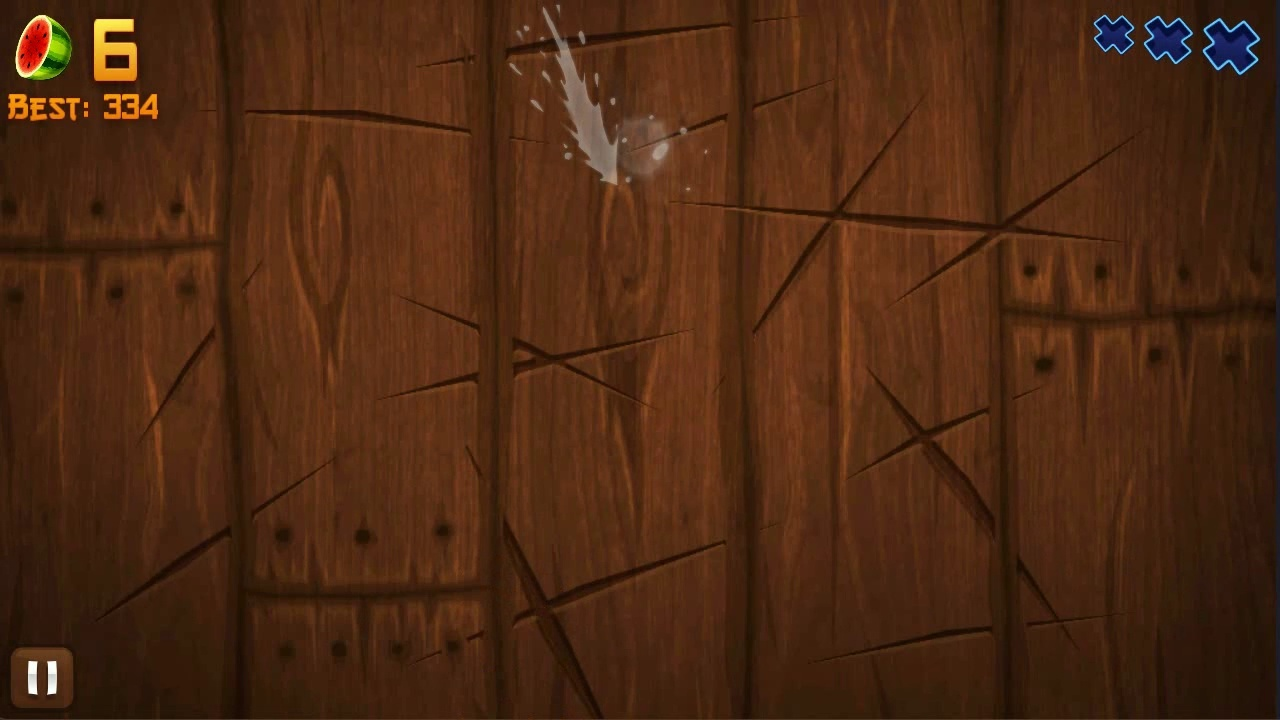

fruitninja1_000418.jpg


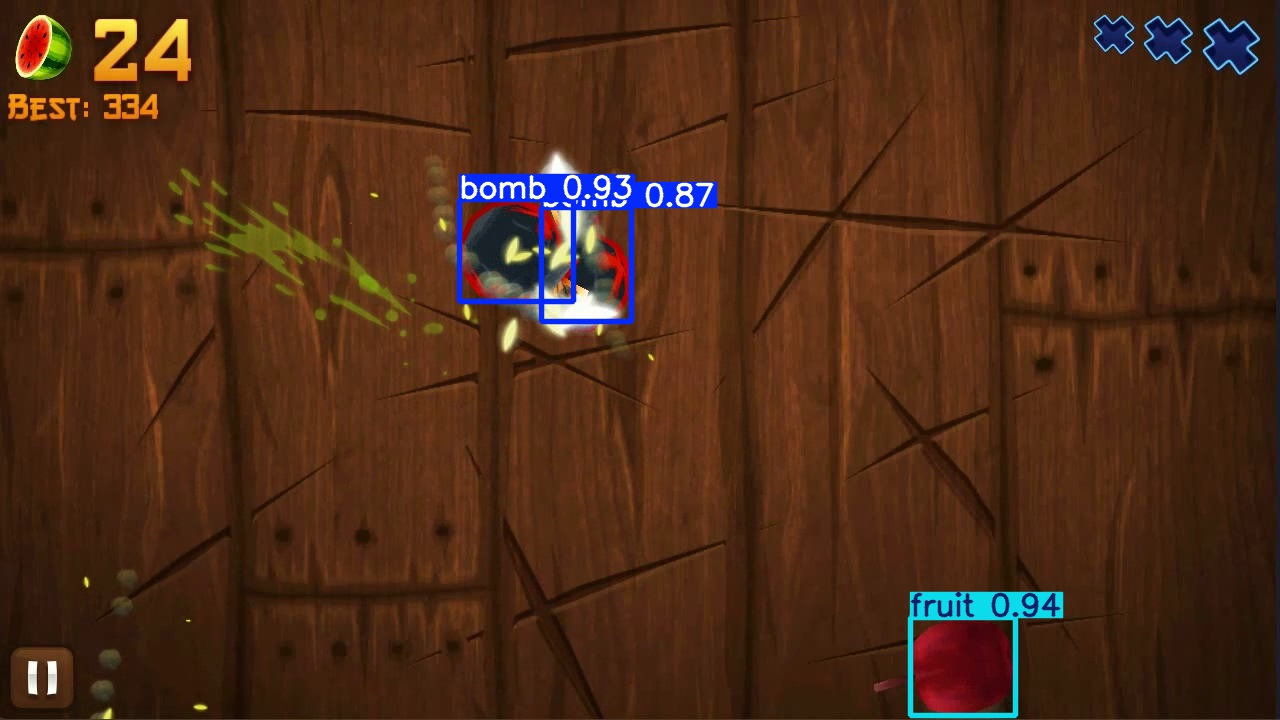

fruitninja1_000533.jpg


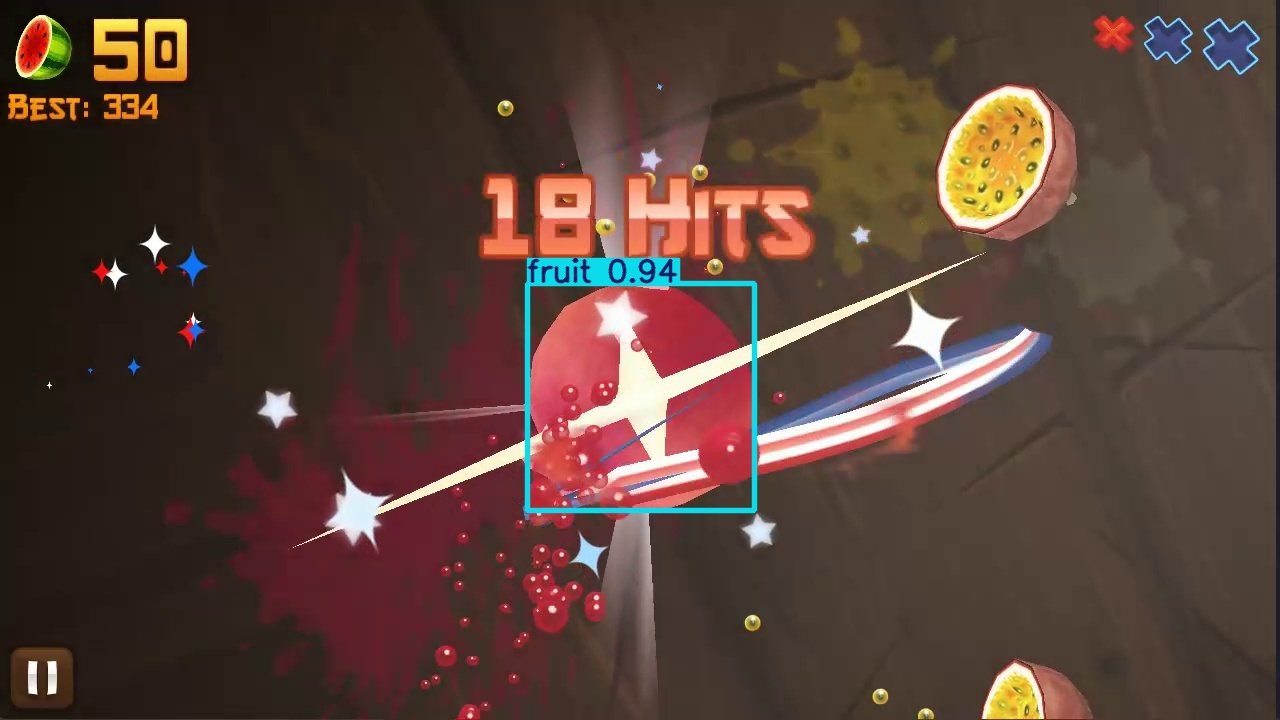

fruitninja1_000647.jpg


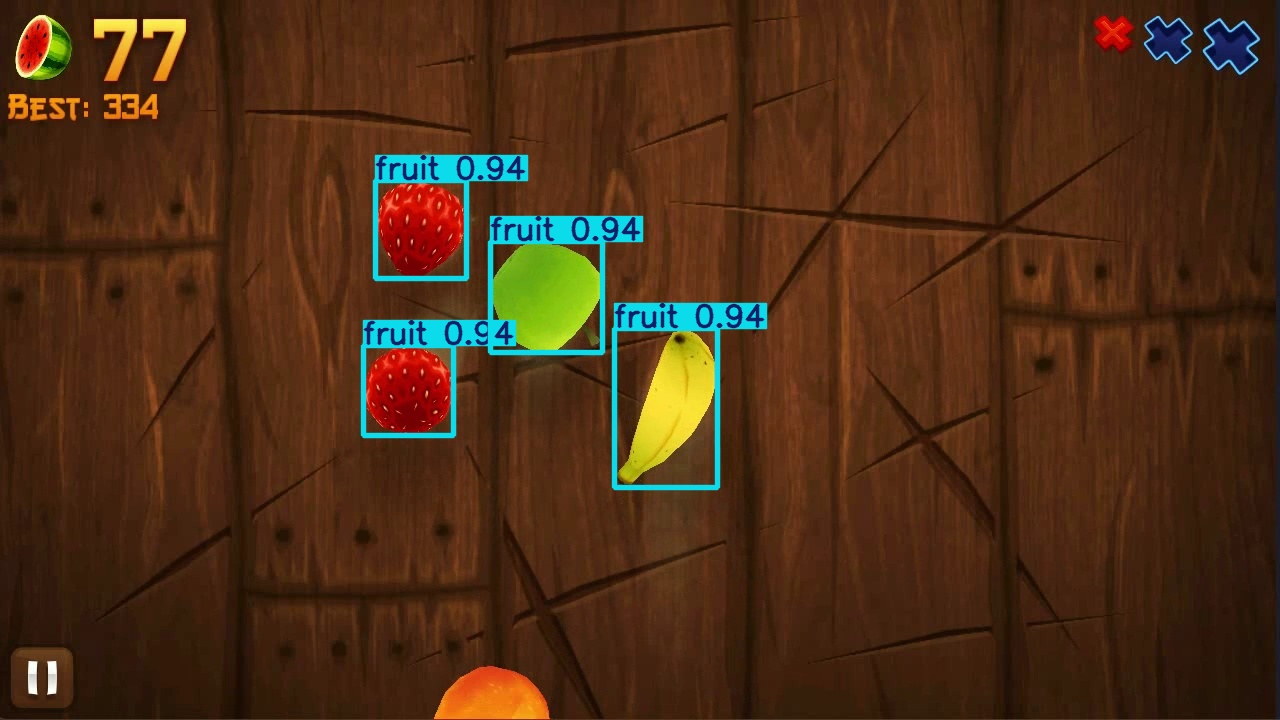

fruitninja1_000889.jpg


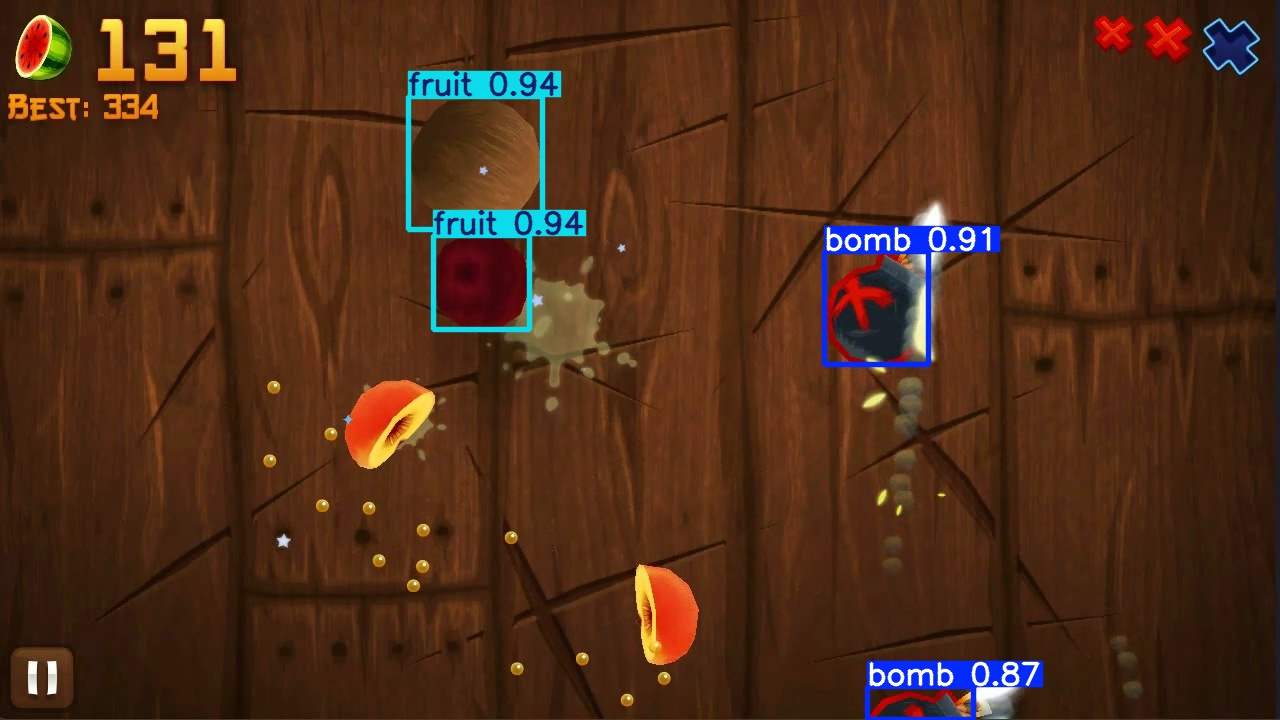

fruitninja1_000906.jpg


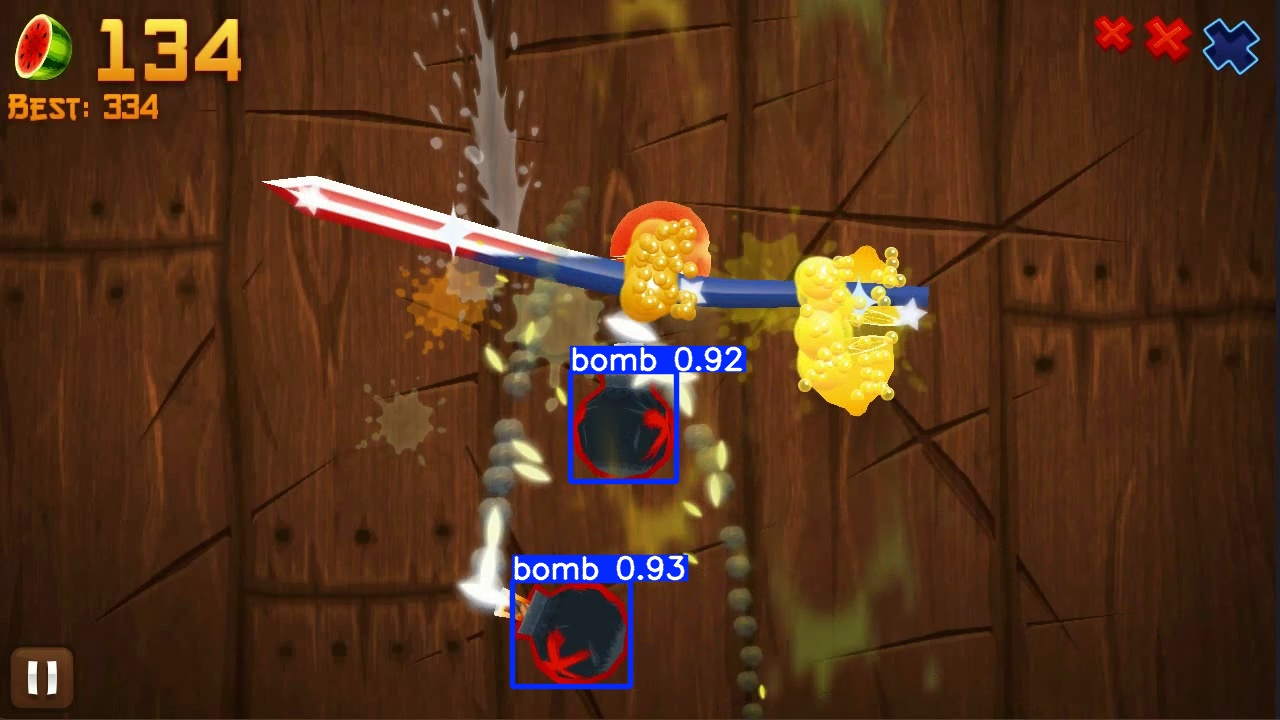

fruitninja1_000976.jpg


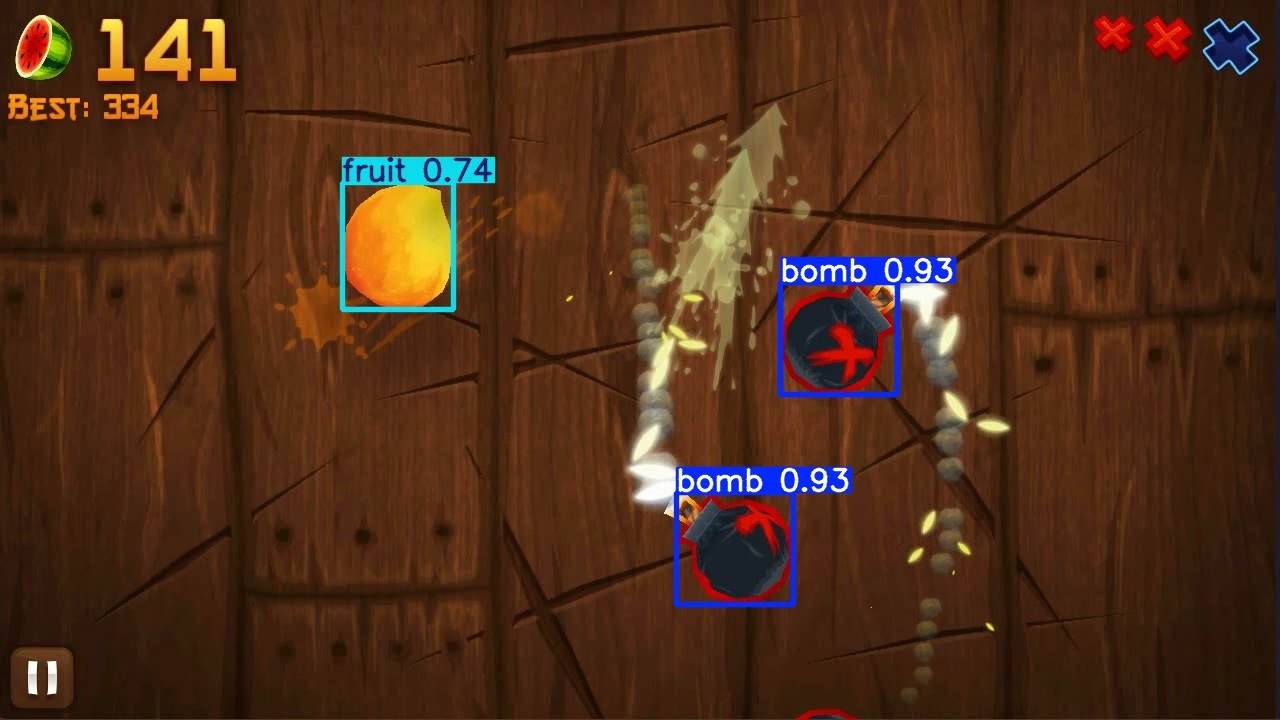

fruitninja2_000040.jpg


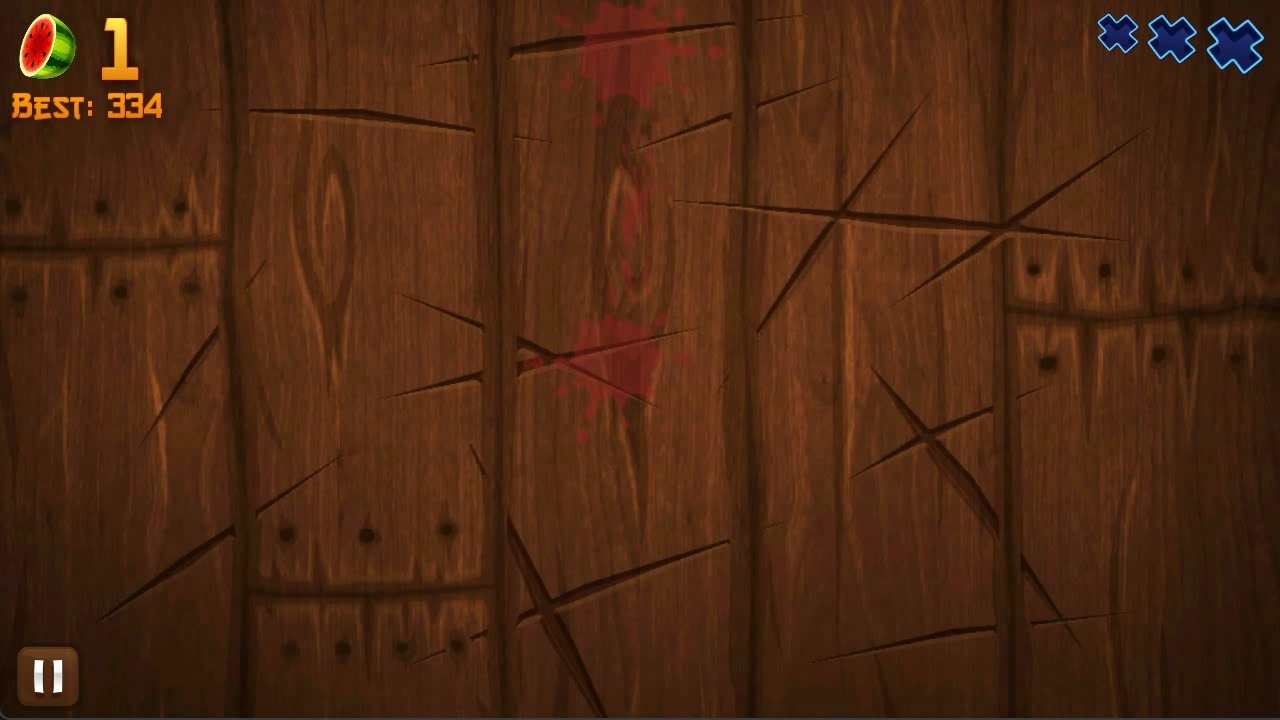

In [12]:
import random

images_dir = project_root / "dataset" / "raw_frames"
all_images = sorted(images_dir.glob("*.jpg"))
if not all_images:
    all_images = sorted(images_dir.glob("*.png"))

print(f"Found {len(all_images)} images.")

sample_images = random.sample(all_images, k=min(12, len(all_images)))
sample_rel = [p.relative_to(project_root) for p in sample_images]
sample_rel[:5]

viz_name = "fruitninja_sample_preds"

results = model.predict(
    source=[str(p) for p in sample_images],
    save=True,
    project=str(models_dir),
    name=viz_name,
    exist_ok=True,
)

print("Saved annotated images under:", (models_dir / viz_name).relative_to(project_root))

viz_dir = models_dir / viz_name

for img_path in sorted(viz_dir.glob("*.jpg"))[:8]:
    print(img_path.name)
    display(Image(filename=str(img_path)))